In [1]:
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# Query expansion analysis

In [2]:
filenames = [
    "outputs/metrics_k15_typesentences_size10.json",
    "outputs/query/metrics_k15_typesentences_size10_method_llm_ans.json",
    "outputs/query/metrics_k15_typesentences_size10_method_llm_multiquery.json"
]

In [6]:
filenames = [
    "outputs/metrics_k15_typewords_size50.json",
    "outputs/query/metrics_k15_typewords_size50_method_llm_ans.json",
    "outputs/query/metrics_k15_typewords_size50_method_llm_multiquery.json"
]

In [7]:
# loading the metrics from the json files for query
list_vals = []
for metrics_filename in filenames:
    metrics = json.load(open(metrics_filename))
    #toAdd = {"k": TOP_K, "chunk_type": CHUNK_TYPE, "chunk_size": CHUNK_SIZE}

    # For now I'll only load the full dataset metrics, change this if you want to load the other ones.
    dict_metrics = metrics['full_dataset']['full_dataset']
    #toAdd |= dict_metrics
    list_vals.append(dict_metrics)

In [8]:
df = pd.DataFrame(list_vals)
df.drop(['sample_size',"avg_llm_response","avg_total", "EM"] , axis=1, inplace=True)
df["experiment_type"] = ["original", "llm_ans", "llm_multiquery"]
df.set_index("experiment_type", inplace=True)

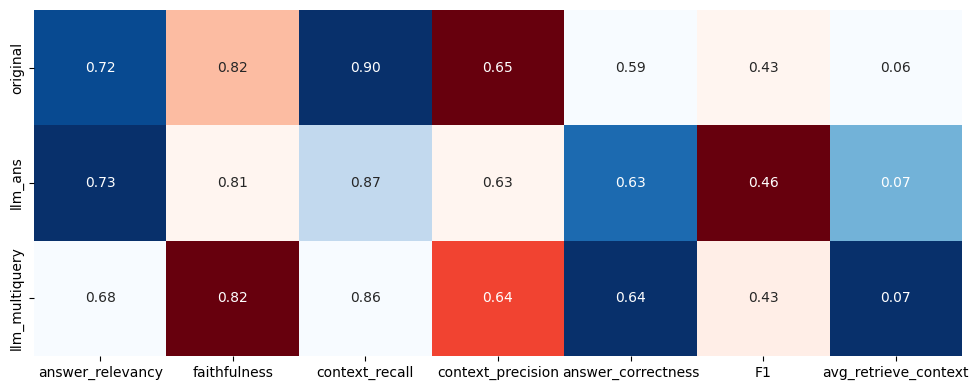

In [9]:
cmaps = ['Blues', 'Reds', 'Blues', 'Reds','Blues', 'Reds', 'Blues']

# One subplot per column, arranged horizontally
fig, axs = plt.subplots(1, len(df.columns), figsize=(10, 4), gridspec_kw={'wspace': 0})
df.index.name = None
for i, col in enumerate(df.columns):
    col_data = df[[col]]  # Keep it as DataFrame to retain index labels
    show_yticks = i == 0  # Show yticklabels only on first and last
    sns.heatmap(
        col_data,
        annot=True,
        fmt='.2f',
        cmap=cmaps[i % len(cmaps)],
        yticklabels=col_data.index if show_yticks else False,
        xticklabels=[col],
        ax=axs[i],
        cbar=False
    )

plt.tight_layout()
plt.show()

# Chunking experiment analysis code

In [68]:
# List of experiments, with k, chunk type, chunk size.
list_chunks = [
(2, 'words', 50),
(2, 'words', 300),
(2, 'words', 500),
(5, 'words', 50),
(5, 'words', 300),
(5, 'words', 500),
(10, 'words', 50),
(10, 'words', 300),
(10, 'words', 500),
(15, 'words', 50),
(15, 'words', 300),
(15, 'words', 500),
(2, 'sentences', 10),
(2, 'sentences', 50),
(2, 'sentences', 100),
(5, 'sentences', 10),
(5, 'sentences', 50),
(5, 'sentences', 100),
(10, 'sentences', 10),
(10, 'sentences', 50),
(10, 'sentences', 100),
(15, 'sentences', 10),
(15, 'sentences', 50),
(15, 'sentences', 100),
(20, 'sentences', 10),
(25, 'sentences', 10),
(2, 'paragraphs', 1),
(2, 'paragraphs', 5),
(2, 'paragraphs', 10),
(2, 'paragraphs', 15),
(5, 'paragraphs', 1),
(5, 'paragraphs', 5),
(5, 'paragraphs', 10),
(5, 'paragraphs', 15),
(10, 'paragraphs', 1),
(10, 'paragraphs', 5),
(10, 'paragraphs', 10),
(10, 'paragraphs', 15),
(15, 'paragraphs', 1),
(15, 'paragraphs', 5),
(15, 'paragraphs', 10),
(15, 'paragraphs', 15),
#(1, 'pages', 1),
(2, 'pages', 1),
(5, 'pages', 1),
(10, 'pages', 1),
(15, 'pages', 1),
]

In [69]:
k_list = [2, 5, 10, 15]


In [70]:
# loading the metrics from the json files
list_vals = []
for TOP_K, CHUNK_TYPE, CHUNK_SIZE in list_chunks:
    metrics_filename = f"outputs/metrics_k{TOP_K}_type{CHUNK_TYPE}_size{CHUNK_SIZE}.json"
    metrics = json.load(open(metrics_filename))
    toAdd = {"k": TOP_K, "chunk_type": CHUNK_TYPE, "chunk_size": CHUNK_SIZE}

    # For now I'll only load the full dataset metrics, change this if you want to load the other ones.
    dict_metrics = metrics['full_dataset']['full_dataset']
    toAdd |= dict_metrics
    list_vals.append(toAdd)

In [71]:
df = pd.DataFrame(list_vals)

In [72]:
df.head()

,k,chunk_type,chunk_size,answer_relevancy,faithfulness,context_recall,context_precision,answer_correctness,EM,F1,avg_retrieve_context,avg_llm_response,avg_total,sample_size
0,2,words,50,0.605545,0.765455,0.714318,0.763636,0.603506,0.054545,0.404558,0.058654,1.102986,1.161640,110
1,2,words,300,0.672901,0.830411,0.807576,0.759091,0.655461,0.072727,0.453499,0.058809,1.230641,1.289450,110
2,2,words,500,0.649961,0.784545,0.850000,0.813636,0.643772,0.090909,0.472971,0.063309,1.113785,1.177094,110
3,5,words,50,0.658820,0.824562,0.816970,0.731414,0.617743,0.063636,0.458147,0.070781,1.336184,1.406965,110
4,5,words,300,0.708026,0.801487,0.926515,0.743333,0.681700,0.063636,0.493760,0.068165,1.254819,1.322983,110


Code for getting bubble heatmap:
1. get the data read in for each rfp type + k, chunk_type, chunk_size, etc
2. calc std
3. add that to the df
4. get bubble heatmap


In [73]:
# loading the metrics from the json files
list_vals = []
for TOP_K, CHUNK_TYPE, CHUNK_SIZE in list_chunks:
    metrics_filename = f"outputs/metrics_k{TOP_K}_type{CHUNK_TYPE}_size{CHUNK_SIZE}.json"
    metrics = json.load(open(metrics_filename))
        #toAdd = {"k": TOP_K, "chunk_type": CHUNK_TYPE, "chunk_size": CHUNK_SIZE, "negative_rejection": metrics["negative_rejection_percentage"]}

        # For now I'll only load the full dataset metrics, change this if you want to load the other ones.
    rfps = metrics['RFP_id']
    for rfp in rfps.keys():
        toAdd = {"k": TOP_K, "chunk_type": CHUNK_TYPE, "chunk_size": CHUNK_SIZE, "rfp_id": rfp}
        dict_metrics = rfps[rfp]
        toAdd |= dict_metrics
        list_vals.append(toAdd)
df_rfp = pd.DataFrame(list_vals)

In [74]:
list_metrics = ["answer_relevancy","faithfulness", 'context_recall','context_precision', 
                'answer_correctness', 'EM', 'F1',
                'avg_retrieve_context', 'avg_llm_response', 'avg_total', 'sample_size']

df_grouped = df_rfp.groupby(['k', 'chunk_type', 'chunk_size']).apply(lambda x: x[list_metrics].std()).reset_index()
df_final = pd.merge(df, df_grouped, on = ['k', 'chunk_type', 'chunk_size'], how='left', suffixes=('', '_std'))

/tmp/ipykernel_81387/2623827307.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df_rfp.groupby(['k', 'chunk_type', 'chunk_size']).apply(lambda x: x[list_metrics].std()).reset_index()


In [75]:
def std_scatterplot(df_final, metric = "faithfulness"):
    metric_std = metric + "_std"
    toPlot = df_final[["k", "chunk_type", "chunk_size", metric, metric_std]]
    toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)
    ax = sns.scatterplot(
        data=toPlot,
        x="chunk",
        y="k",
        size=metric_std,
        hue = metric,
        sizes=(20, 2000),
        palette = "crest"
    )
    ax.set_title(metric)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    # show the graph
    plt.xticks(rotation=45, ha='right') 
    plt.show()

/tmp/ipykernel_81387/1379580958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)


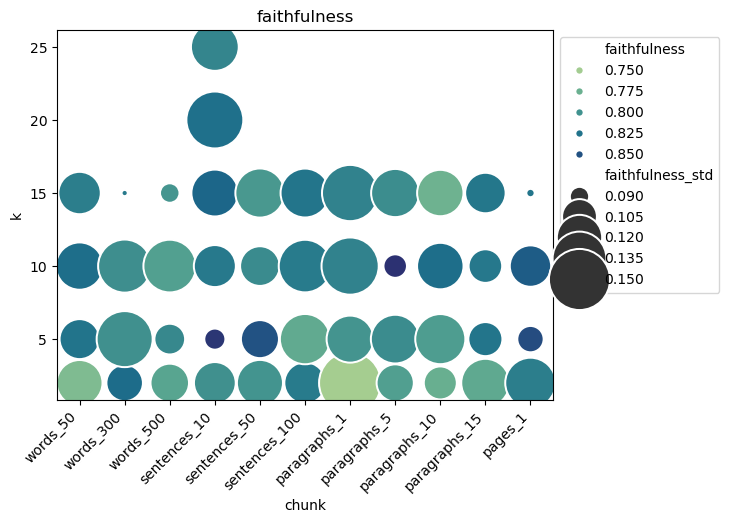

In [76]:
std_scatterplot(df_final,"faithfulness")

/tmp/ipykernel_81387/1379580958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)


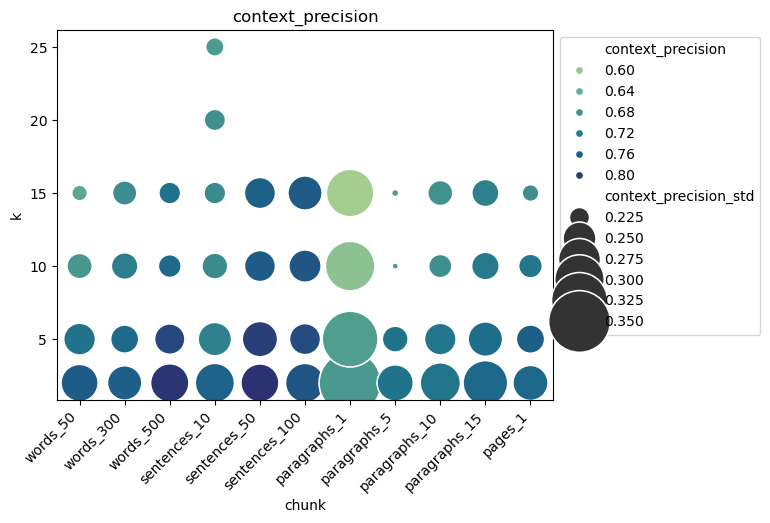

In [77]:
std_scatterplot(df_final,"context_precision")

/tmp/ipykernel_81387/1379580958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)


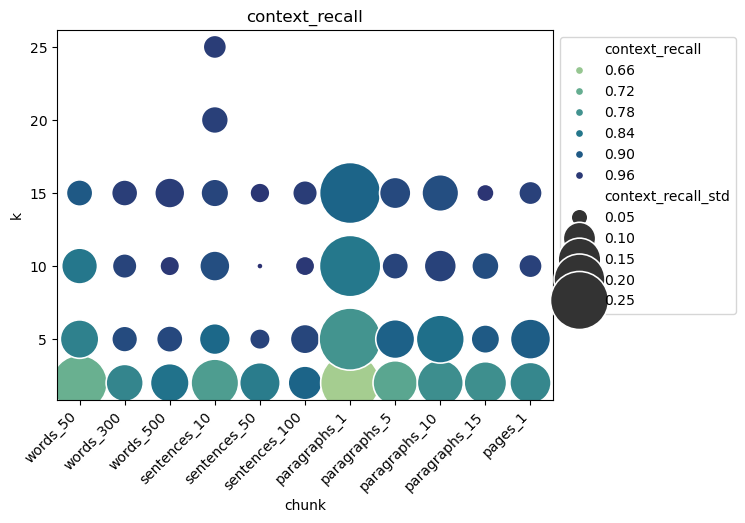

In [78]:
std_scatterplot(df_final,"context_recall")

/tmp/ipykernel_81387/1379580958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)


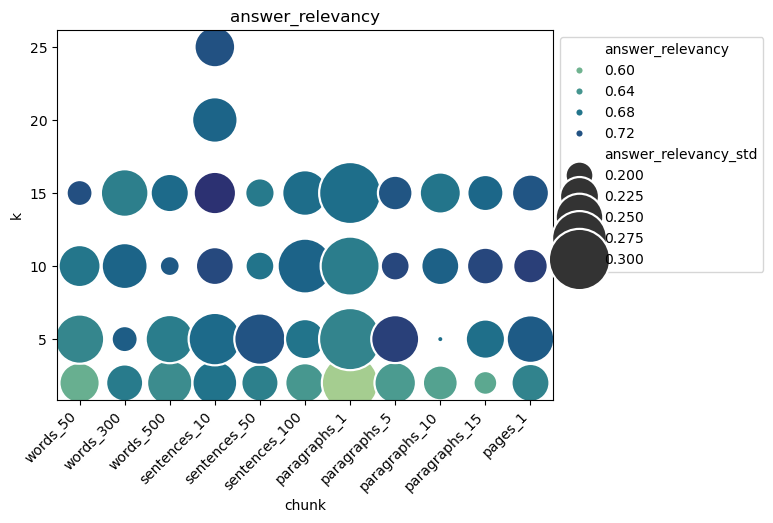

In [79]:
std_scatterplot(df_final,"answer_relevancy")

/tmp/ipykernel_81387/1379580958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toPlot["chunk"] = toPlot["chunk_type"] + "_" + toPlot["chunk_size"].astype(str)


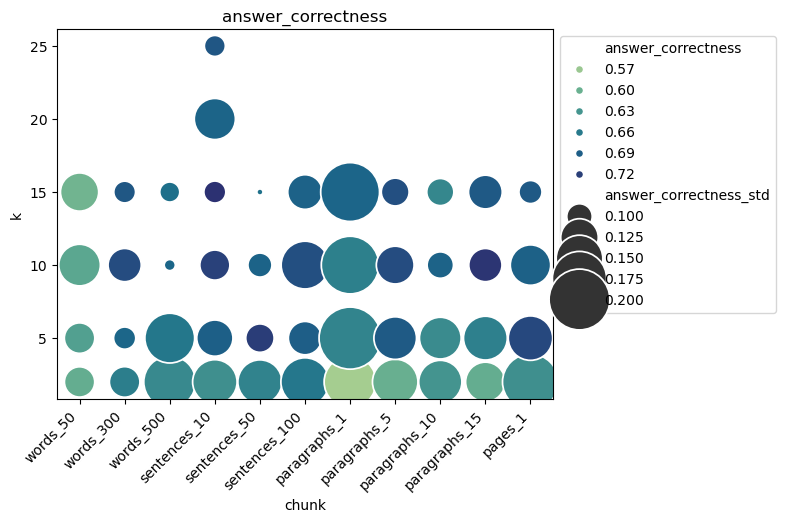

In [80]:
std_scatterplot(df_final,"answer_correctness")

In [81]:
# Plot the heatmap for mean values
plt.figure(figsize=(8, 6))
ax = sns.heatmap(toPlot.pivot(index=["chunk"], columns="k", values=[metric]), annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mean Value'})

# Overlay bubbles based on standard deviation values (size of bubbles)
for i in range(toPlot[metric].shape[0]):
    for j in range(toPlot["chunk"].shape[0]):
        # You can adjust the bubble size based on the standard deviation value
        ax.scatter(j + 0.5, i + 0.5, s=toPlot[metric_std].iloc[i] * 500, c='red', alpha=0.5, edgecolors='black')

plt.title('Bubble Heatmap with Mean and Standard Deviation')
plt.show()


NameError: name 'toPlot' is not defined

<Figure size 800x600 with 0 Axes>

# Older stuff - heatmap without std

In [82]:
def single_type_heatmap(df, chunk_type = "words", metric = "faithfulness"):
    """Pass in chunk_type and metric as strings from the dataframe columns."""
    toPlot = df[df.chunk_type==chunk_type][["k", "chunk_size", metric]]
    sns.heatmap(toPlot.pivot(index="k", columns="chunk_size", values=metric), cmap = "crest", annot = True).set_title("Chunk by "+chunk_type)

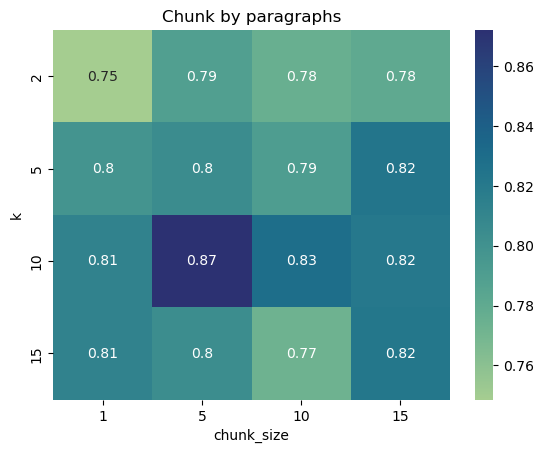

In [ ]:
single_type_heatmap(df, "paragraphs", "faithfulness")


In [83]:
def all_chunks_heatmap(df, metric = "faithfulness"):
    toPlot = df[["k", "chunk_type", "chunk_size", metric]]
    sns.heatmap(toPlot.pivot(index=["chunk_type", "chunk_size"], columns="k", values=metric), cmap = "crest", annot = True).set_title(metric + " by chunks")

,k,chunk_type,chunk_size,rfp_id,answer_relevancy,faithfulness,context_recall,context_precision,answer_correctness,EM,F1,avg_retrieve_context,avg_llm_response,avg_total,sample_size
0,2,words,50,infra_1,0.635032,0.865079,0.596825,0.857143,0.563162,0.000000,0.271523,0.058654,1.366676,1.425330,21
1,2,words,50,infra_2,0.716019,0.737179,0.923077,0.884615,0.664090,0.076923,0.551371,0.058654,1.424742,1.483396,13
2,2,words,50,infra_3,0.543461,0.763889,0.625000,0.750000,0.570266,0.000000,0.326104,0.058654,0.684769,0.743423,12
3,2,words,50,infra_4,0.538354,0.744048,0.491071,0.928571,0.444594,0.000000,0.306448,0.058654,1.215387,1.274041,14
4,2,words,50,natsec_1,0.440090,0.666667,0.500000,0.666667,0.556234,0.000000,0.196523,0.058654,0.641381,0.700035,6


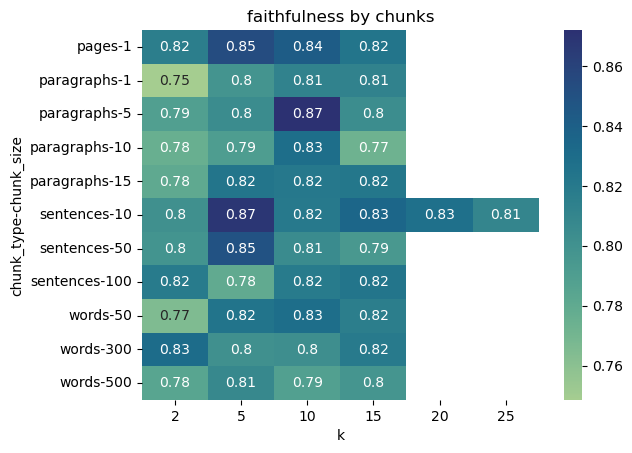

In [84]:
all_chunks_heatmap(df, "faithfulness")
df_rfp.head()

In [85]:
all_chunks_heatmap(df_rfp, "negative_rejection")

KeyError: "['negative_rejection'] not in index"

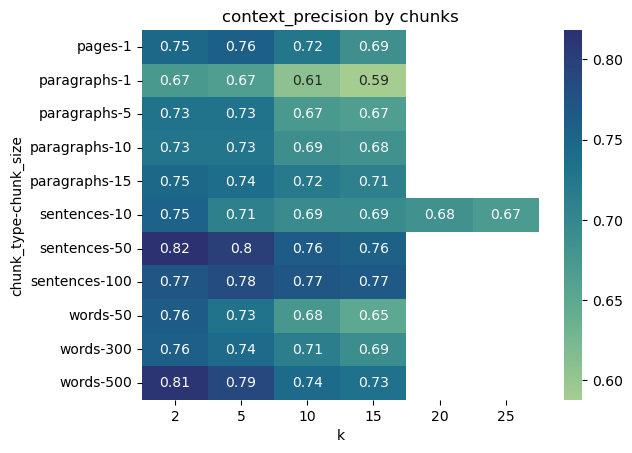

In [86]:
all_chunks_heatmap(df, "context_precision")

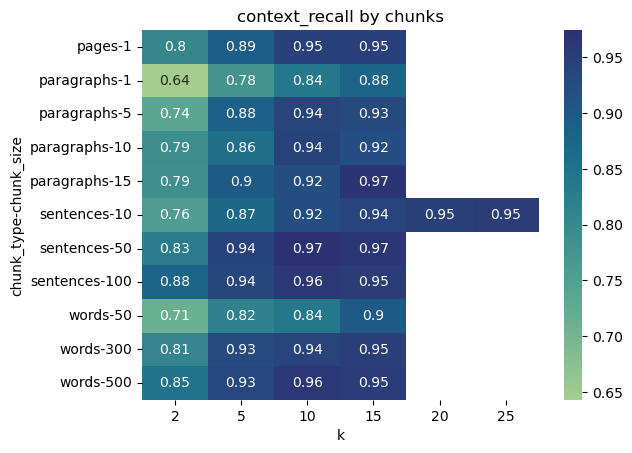

In [87]:
all_chunks_heatmap(df, "context_recall")

In [79]:
import nltk

nltk.download()


2025-04-11 01:04:48.438 Python[49804:1378809] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-11 01:04:48.438 Python[49804:1378809] +[IMKInputSession subclass]: chose IMKInputSession_Modern


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

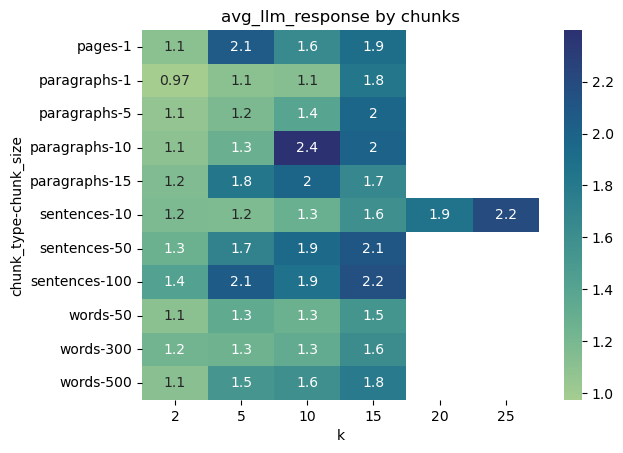

In [53]:
all_chunks_heatmap(df, "avg_llm_response")

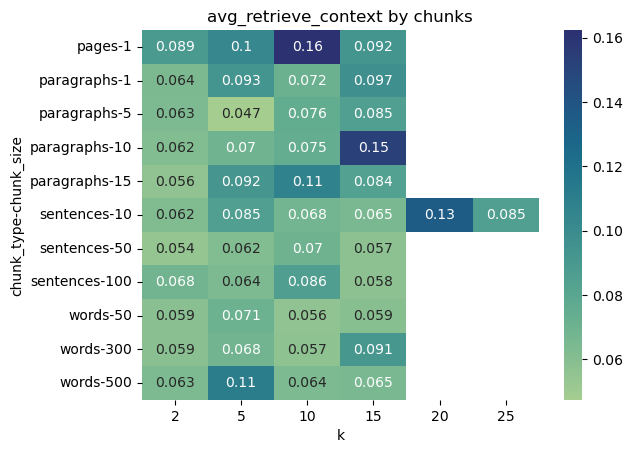

In [89]:
all_chunks_heatmap(df, "avg_retrieve_context")

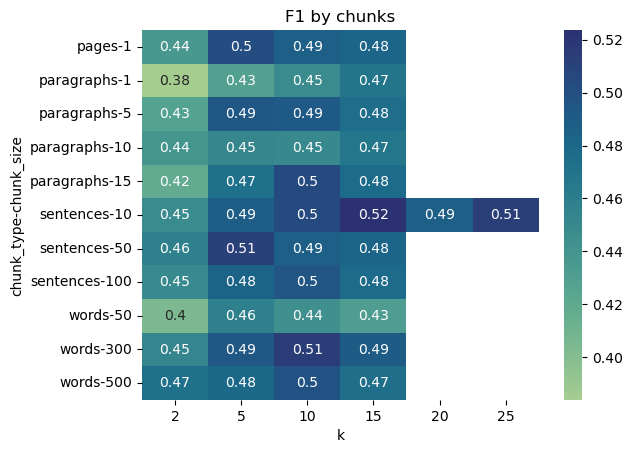

In [90]:
all_chunks_heatmap(df, "F1")

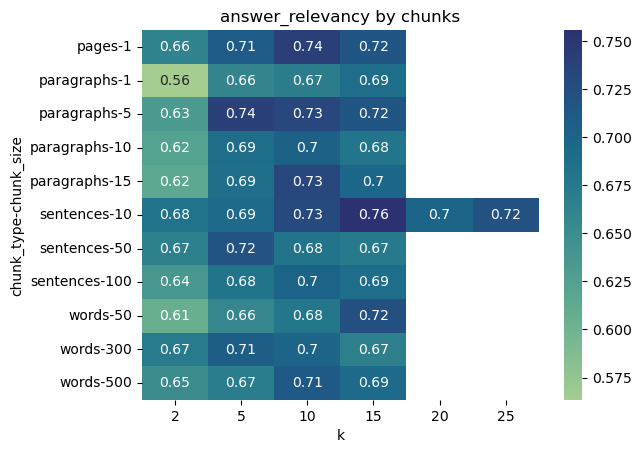

In [91]:
all_chunks_heatmap(df, "answer_relevancy")

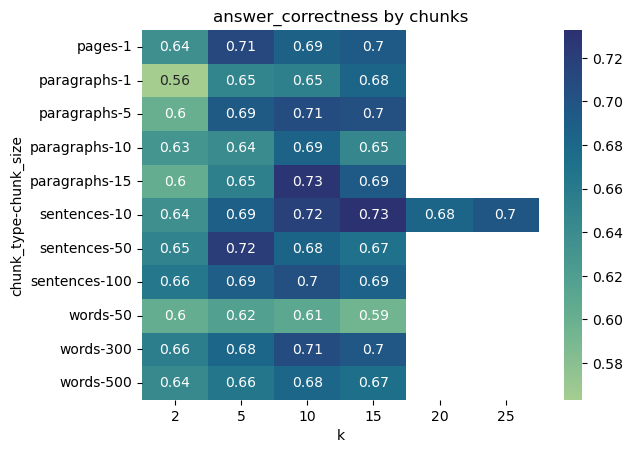

In [92]:
all_chunks_heatmap(df, "answer_correctness")